In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
def extract(TICKERS, start, end):
    def data(ticker):
        return web.DataReader(ticker, "yahoo", start, end)
    S = map(data, TICKERS)
    return pd.concat(S, keys = TICKERS, names = ["Ticker", "Date"])

In [3]:
s = ['MSFT', 'AMD', 'TSLA', 'TSM']
start = dt.date(2019, 1, 1)
end = dt.date(2020, 12, 30)
T4 = extract(s, start, end)

In [4]:
T4 = T4[['Adj Close']]
T4 = T4.reset_index().set_index('Date')

In [5]:
T4_pct = pd.DataFrame(index = T4.index)
for i, j in T4.groupby('Ticker'):
    temp = j['Adj Close']
    temp.name = i
    T4_pct = pd.merge(T4_pct, temp, on = 'Date')

In [6]:
T4_pct = T4_pct.pct_change().dropna()

In [7]:
def kill1(x):
    if x == 1:
        return 0
    else: 
        return x

In [8]:
for i in T4_pct.corr():
    print(T4_pct.corr()[i].nlargest(2))

AMD     1.000000
MSFT    0.614515
Name: AMD, dtype: float64
MSFT    1.00000
TSM     0.61497
Name: MSFT, dtype: float64
TSLA    1.000000
MSFT    0.461972
Name: TSLA, dtype: float64
TSM     1.00000
MSFT    0.61497
Name: TSM, dtype: float64


<p>correlated pair:</p>

<p>Best trading pair: MSFT & TSM</p>
    

In [9]:
def data(ticker):
        return web.DataReader(ticker, "yahoo", start, end)

def long_or_short(x):
    if x["Adj Close"] < x["LongPoint"]:
        return 1
    elif x["Adj Close"] > x["ShortPoint"]:
        return -1
    else:
        return 0


In [15]:
msft = data('MSFT')[['Adj Close']]

msft['SMA42'] = msft['Adj Close'].rolling(10).mean()

msft['ShortPoint'] = msft['Adj Close'].rolling(10).mean() + msft['Adj Close'].rolling(10).std() * 2
msft['LongPoint'] = msft['Adj Close'].rolling(10).mean() - msft['Adj Close'].rolling(10).std() * 2

msft["Position"] = 0
msft = msft.dropna()

msft["Position"] = msft.apply(long_or_short, axis = 1)

msft["our_positions"] = msft["Position"].diff()

In [17]:
tsm = data('TSM')[['Adj Close']]

tsm['SMA42'] = tsm['Adj Close'].rolling(10).mean()

tsm['ShortPoint'] = tsm['Adj Close'].rolling(10).mean() + tsm['Adj Close'].rolling(10).std() * 2
tsm['LongPoint'] = tsm['Adj Close'].rolling(10).mean() - tsm['Adj Close'].rolling(10).std() * 2

tsm["Position"] = 0
tsm = tsm.dropna()

tsm["Position"] = tsm.apply(long_or_short, axis = 1)

tsm["our_positions"] = tsm["Position"].diff()

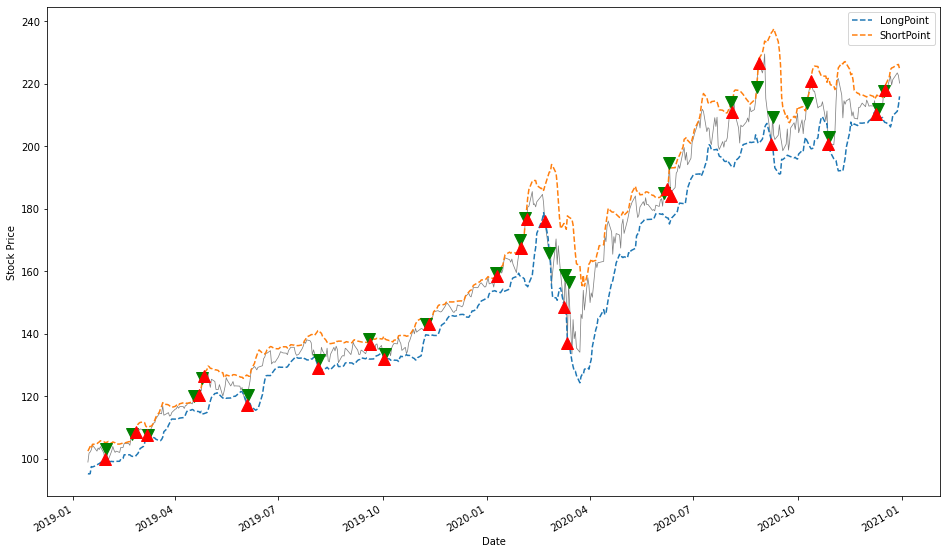

In [16]:
fig = plt.figure(figsize = (16, 10))

sub = fig.add_subplot(111,
                      ylabel = "Stock Price")

msft["Adj Close"].plot(ax = sub,
                      color = "grey",
                      lw = 0.75) # Closing Price

msft[["LongPoint",
        "ShortPoint"]].plot(ax = sub,
                               style = ["--", "--"]
                               )

sub.plot(msft.loc[msft.our_positions == -1.0].index, # Selling
         msft["Adj Close"][msft.our_positions == -1.0], 
         "v",
         color = "green",
         markersize = 12)

sub.plot(msft.loc[msft.our_positions == 1.0].index, # Buying
         msft["Adj Close"][msft.our_positions == 1.0], 
         "^",
         color = "red",
         markersize = 12)

plt.show()

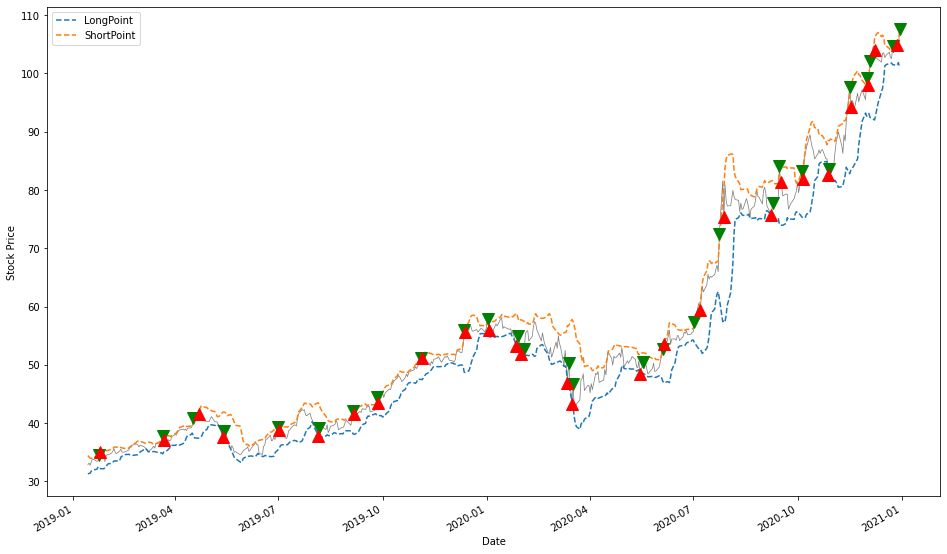

In [18]:
fig = plt.figure(figsize = (16, 10))

sub = fig.add_subplot(111,
                      ylabel = "Stock Price")

tsm["Adj Close"].plot(ax = sub,
                      color = "grey",
                      lw = 0.75) # Closing Price

tsm[["LongPoint",
        "ShortPoint"]].plot(ax = sub,
                               style = ["--", "--"]
                               )

sub.plot(tsm.loc[tsm.our_positions == -1.0].index, # Selling
         tsm["Adj Close"][tsm.our_positions == -1.0], 
         "v",
         color = "green",
         markersize = 12)

sub.plot(tsm.loc[tsm.our_positions == 1.0].index, # Buying
         tsm["Adj Close"][tsm.our_positions == 1.0], 
         "^",
         color = "red",
         markersize = 12)

plt.show()

In [19]:
capital = 200000

In [24]:
msft["our_holdings"] = (msft["our_positions"].multiply(msft["Adj Close"],axis = 0))
difference_in_shares_owned = msft["our_positions"].diff()
msft["our_cash"] = capital - difference_in_shares_owned.multiply(msft["Adj Close"]).cumsum()
msft["total"] = msft["our_cash"] + msft["our_holdings"]
msft['return'] = msft["total"].pct_change()
np.sqrt(253) * msft['return'].mean() / msft['return'].std()

1.5668284769344463

In [25]:
tsm["our_holdings"] = (tsm["our_positions"].multiply(tsm["Adj Close"],axis = 0))
difference_in_shares_owned = tsm["our_positions"].diff()
tsm["our_cash"] = capital - difference_in_shares_owned.multiply(tsm["Adj Close"]).cumsum()
tsm["total"] = tsm["our_cash"] + tsm["our_holdings"]
tsm['return'] = tsm["total"].pct_change()
np.sqrt(253) * tsm['return'].mean() / tsm['return'].std()

1.3827734355013874

In [26]:
msft.tail(1)

,Adj Close,SMA42,ShortPoint,LongPoint,Position,our_positions,our_holdings,our_cash,total,return
Date,,,,,,,,,,
2020-12-30,220.239426,220.396422,224.816807,215.976037,0,0.0,0.0,200085.669731,200085.669731,0.0


In [27]:
tsm.tail(1)

,Adj Close,SMA42,ShortPoint,LongPoint,Position,our_positions,our_holdings,our_cash,total,return
Date,,,,,,,,,,
2020-12-30,107.634552,103.982288,107.061966,100.902609,-1,-1.0,-107.634552,200141.042599,200033.408047,0.0
